In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, spearmanr
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize 

In [2]:
from myLibrary.functions import *

# Problem 1

please check details in test_function.py

# Problem 2

In [3]:
data1 = pd.read_csv('problem1.csv')

In [4]:
num_simulations = 100000

Using a normal distribution with an exponentially weighted variance (lambda=0.97)

In [5]:
mu, sigma = fit_normal(data1, method='ew')
VaR_normal = VaR_norm(mu, sigma)
ES_normal = ES_norm(mu, sigma)
sim_normal = np.random.normal(mu, sigma, num_simulations)

-0.3870176067852492
-0.005705326111219475


Using a MLE fitted T distribution

In [6]:
df, loc, scale = fit_t(data1)
VaR_t_dist = VaR_t(df, loc, scale)
ES_t_dist = ES_t(df, loc, scale)
sim_t = t.rvs(df, loc=loc, scale=scale, size=num_simulations)

-33.48961126419782
-0.00566089936642061


/home/yy404/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Using a Historic Simulation 

In [7]:
VaR_historical, ES_historical= VaR_hist(data1)

In [8]:
def plot_histogram_with_var(series, var, es, title):
    """Plot the distribution for the series with the VaR marked on the figure"""
    plt.hist(series, bins=80, density=True, alpha=0.5)
    sns.kdeplot(series, color='g', linewidth=1)
    plt.axvline(-var, color='r', linestyle='--', label=f'VaR = {-var:.2f}')
    plt.axvline(-es, color='b', linestyle='--', label=f'ES = {-es:.2f}')
    plt.title(title)
    plt.legend()
    plt.savefig(title, dpi =300)
    plt.show()

In [9]:
print("VaR of Normal distribution is ",VaR_normal)
print("VaR of T distribution is ",VaR_t_dist)
print("VaR of Historic distribution is ",VaR_historical)
print("ES of Normal distribution is ",ES_normal)
print("ES of T distribution is ",ES_t_dist)
print("ES of Historic distribution is ",ES_historical)

VaR of Normal distribution is  0.09116934315709696
VaR of T distribution is  0.07647560823045704
VaR of Historic distribution is  0.07598069069686242
ES of Normal distribution is  0.1141065222243895
ES of T distribution is  0.11321798732841219
ES of Historic distribution is  0.11677669788562187


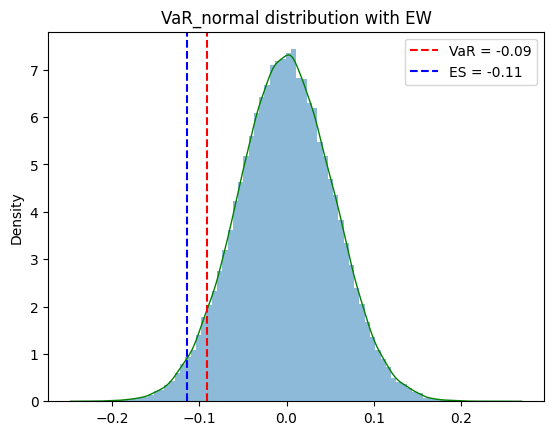

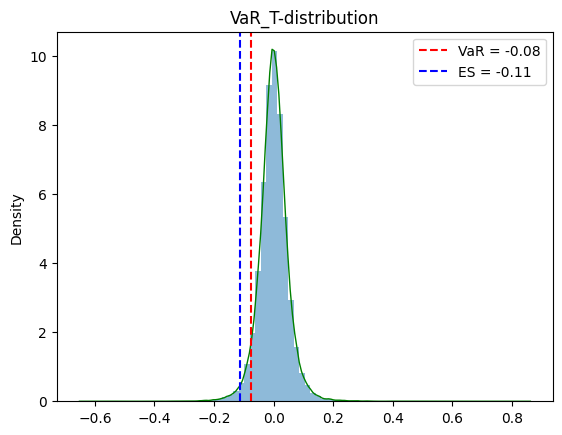

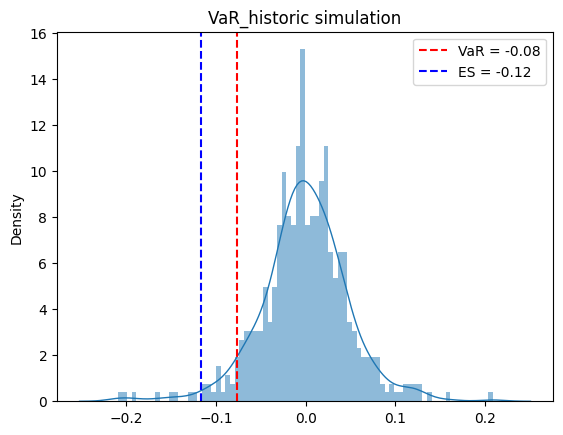

In [36]:
plot_histogram_with_var(sim_normal, VaR_normal, ES_normal, "VaR_normal distribution with EW")
plot_histogram_with_var(sim_t, VaR_t_dist, ES_t_dist, "VaR_T-distribution")
plot_histogram_with_var(data1, VaR_historical, ES_historical, "VaR_historic simulation")

# Problem 3

Calculate arithmetic returns

In [30]:
prices = pd.read_csv('DailyPrices.csv')
# current_prices = prices.iloc[-1,:]
returns_all = return_calculate(prices)
portfolio = pd.read_csv("portfolio.csv")
returns_all.iloc[:, 1:] = returns_all.iloc[:, 1:].apply(lambda x: x - x.mean(), axis=0)
returns_all.drop('Date', axis=1, inplace=True)

In [31]:
stocks = portfolio[portfolio['Portfolio'] == 'A']['Stock']
current_prices = prices.loc[:,stocks].tail(1)

In [126]:
def calculate_portfolio_VaR_ES(portfolio_name, prices, portfolio_info,model ='t'):
    returns_all = return_calculate(prices)
    returns_all.iloc[:, 1:] = returns_all.iloc[:, 1:].apply(lambda x: x - x.mean(), axis=0)
    returns_all.drop('Date', axis=1, inplace=True)

    if portfolio_name.upper() == 'ALL':
        portfolio_holding = portfolio.loc[:,['Stock','Holding']]
        stocks = portfolio['Stock']
    else:      
        portfolio_holding = portfolio[portfolio['Portfolio'] == portfolio_name].loc[:,['Stock','Holding']]
        stocks = portfolio[portfolio['Portfolio'] == portfolio_name]['Stock']
    current_prices = prices.loc[:,stocks].tail(1)
    stocks = stocks.reset_index(drop=True)
    fittedModel = {}
    
    if model == 't':
        for stock in stocks:
            fittedModel[stock] = fit_t(returns_all[stock])
    elif model == 'normal':
        for stock in stocks:
            fittedModel[stock] = fit_normal(returns_all[stock])
    U = pd.DataFrame()
    
    if model == 't':
        for stock, arg in fittedModel.items():
            stock_return = returns_all[stock]
            df, loc, scale = arg
            U[stock] = t.cdf(stock_return,df, loc, scale)
    elif model == 'normal':
        for stock, arg in fittedModel.items():
            stock_return = returns_all[stock]
            mu, sigma = arg
            U[stock] = norm.cdf(stock_return,mu, sigma)

    spcor = spearmanr(U, axis = 0)[0]
    nSim = 1000
    uSim = multivariate_normal_simulation(spcor, nSim,method = 'pca')
    uSim = norm.cdf(uSim,loc=0,scale=1)
    simulatedReturns = pd.DataFrame()
    
    if model == 't':
        for i in range(uSim.shape[1]):
            stock_name = stocks[i]
            df, loc, scale = fittedModel[stock_name]
            simulatedReturns[stock_name] = t.ppf(uSim[:,i],df, loc, scale)
    elif model == 'normal':
        for i in range(uSim.shape[1]):
            stock_name = stocks[i]
            mu, sigma = fittedModel[stock_name]
            simulatedReturns[stock_name] = norm.ppf(uSim[:,i],mu, sigma)
            
    sim_prices = simulatedReturns.mul(current_prices.values.reshape(-1),axis = 1)
    sim_holdings = sim_prices.dot(portfolio_holding['Holding'].values.reshape(-1, 1))
    
    iterations = pd.DataFrame({'iteration': [i for i in range(1, nSim + 1)]})
    values = pd.merge(portfolio_holding, iterations,how='cross')

    nv = len(values)  # Assuming 'values' is a DataFrame as constructed before
    simulatedValue = [0] * nv  # Initialize a list with zeros
    pnl = [0] * nv  # Initialize a list with zeros
    
    for i in range(nv):
        iteration_raw = values.iloc[i]['iteration']
        # Reset iteration to 1 after reaching 100000
        iteration = (iteration_raw % nSim) if iteration_raw == nSim else iteration_raw
        stock = values.iloc[i]['Stock']
        price = prices.loc[0,stock]
        currentValue = values.iloc[i]['Holding']*price
        
        # Ensure that 'simRet' is indexed or accessed correctly; this might need adjustment
        # Assuming 'simRet' has a multi-level index of 'iteration' and 'Stock' or a similar structure
        ret = simulatedReturns.loc[iteration, stock]
        simulatedValue[i] = currentValue * (1 + ret)
        pnl[i] = simulatedValue[i] - currentValue

    values['pnl'] = pnl
    values['simulatedValue'] = simulatedValue

    gdf = values.groupby('iteration')
    totalValues = gdf.aggregate({
        'simulatedValue': 'sum',
        'pnl': 'sum'
    }).reset_index()
    pnl_sum = totalValues['pnl']
    if model == 't':
        Var = VaR_t(fit_t(pnl_sum)[0], fit_t(pnl_sum)[1],fit_t(pnl_sum)[2], alpha=0.05)
        ES = ES_t(fit_t(pnl_sum)[0], fit_t(pnl_sum)[1],fit_t(pnl_sum)[2], alpha=0.05)
    if model == 'normal':
        mu, sigma = fit_normal(pnl_sum)
        Var = VaR_norm(mu, sigma, alpha=0.05)
        ES = ES_norm(mu, sigma, alpha=0.05)

    return Var, ES, sim_holdings

In [72]:
prices = pd.read_csv('DailyPrices.csv')
portfolio = pd.read_csv("portfolio.csv")

In [73]:
var_A, es_A, sim_prices_A= calculate_portfolio_VaR_ES('A', prices, portfolio)

-128379.25453144166
-559.5922273043677


In [88]:
def plot_portfolio_var_es(sim_prices, VaR_T, ES_T, code):
    plt.hist(sim_prices, bins=80, density=True, alpha=0.5)
    sns.kdeplot(sim_prices, color='b', linewidth=1)
    plt.axvline(-VaR_T, color='g', linestyle='--', label='VaR')
    plt.axvline(-ES_T, color='r', linestyle='-', label='ES')
    
    plt.title('Portfolio {} Simulation'.format(code))
    plt.xlabel('Portfolio Loss')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(code + '_Simulation', dpi=300)
    plt.show()
        
    print("For Portfolio {}," .format(code))
    print("VaR is {}" .format(VaR_T))
    print("ES is {}" .format(ES_T))

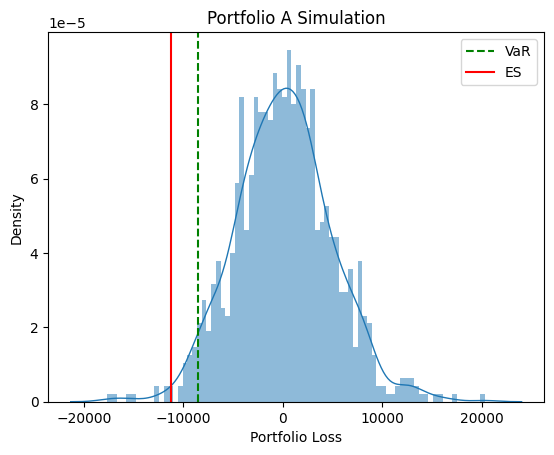

For Portfolio A,
VaR is 8510.502750776115
ES is 11191.844546087354


In [89]:
plot_portfolio_var_es(sim_prices_A,var_A, es_A,'A')

## 运行下面这行就行

-123507.82011710871
-458.0484980363411


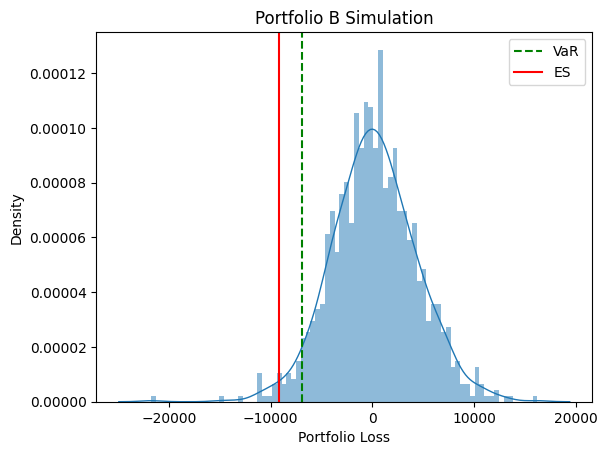

For Portfolio B,
VaR is 6900.865201523558
ES is 9160.969960726821


In [90]:
var_B, es_B, sim_prices_B = calculate_portfolio_VaR_ES('B', prices, portfolio)
plot_portfolio_var_es(sim_prices_B,var_B, es_B,'B')

-26579.678038024995
-393.989416009477


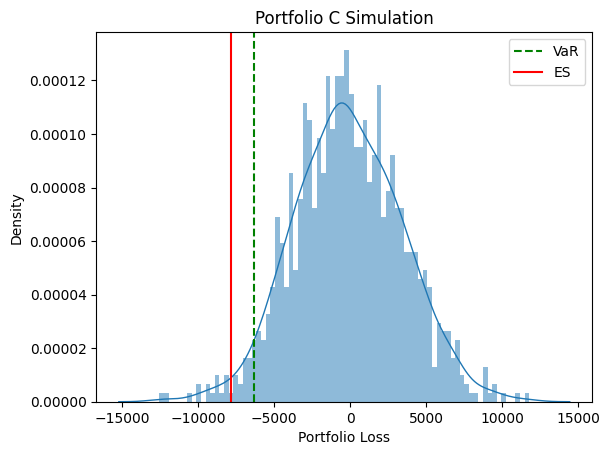

For Portfolio C,
VaR is 6308.130944358026
ES is 7879.788320189539


In [124]:
var_C, es_C, sim_prices_C = calculate_portfolio_VaR_ES('C', prices, portfolio, model ='normal')
plot_portfolio_var_es(sim_prices_C,var_C, es_C,'C')

-517306.3028724501
-1463.5478275924486


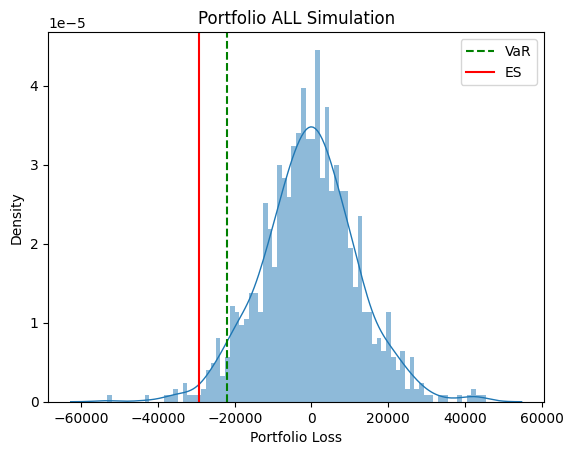

For Portfolio ALL,
VaR is 22112.182001386598
ES is 29270.95655184897


In [128]:
var_All, es_All, sim_prices_All = calculate_portfolio_VaR_ES('ALL', prices, portfolio)
plot_portfolio_var_es(sim_prices_All,var_All, es_All,'ALL')